# Change log: 
* 1.1 - добавлен вывод отчета о FA для текущих недель 
* 1.2 **BUG FIX - service на holdout фактически содержит данные о целевой переменной -> занулили service на holdout**
* 1.5 добавлен TimeSeriesSplit и fbprophet обернут в класс совместимый с sklearn
* 1.6 строим Baseline тотал 46.6
* 1.7 добавили xgb_tree, xgb_lin только на датах тотал 48.2
* 1.8 lasso, xgb_tree, xgb_lin FEATURES_SIMPLE тотал 59.6
* 1.8.1 lasso и xgb_lin FEATURES_SIN_COS тотал 58.6
* 1.8.2 lasso, xgb_lin FEATURES_VECTORS тотал 57.2
* 1.9 все модели из 1.8.* тотал 59.4
* 1.9.1 только xgb_tree FEATURES_SIMPLE тотал 61.6 


* 2.0 с версии 2 начинаем добавлять фичи. Используем только xgb_tree
* 2.0 xgb_tree_features_simple + discount start тотал 61.0
* xgb_tree_features_simple + discount start тотал 59.6
* 2.1 xgb_tree_features_simple + discount start lag 3 тотал 63.6
* 2.3 - outcomes were presented 
* 2.3.1 - advanced prophet was added - 65.4
* 2.4 - art gb was added - **64.2** **упала** 
      -  **BUG FIX - fix custom_ts_cross_val_score func - падала, если меньше 7 дней в одном разбиении**
      - удалена простыня из данных с точностью
      - fbprophet shows errors only if Debug = True
      - Warnings drops if Debug = True
* 2.5 **in progress** - **artem's model switchedd off during development** 


* 2.7 - **Focus Categories BL: holdout: 57% test: 54%**
* 2.7.1 - prophets
    - was:    holdout 66.21%    test 65.06% - cv_len = 21
    - became: holdout 66.74%    test 68.02% - cv_len =  7

* 2.7.2 - prophets
    - holdout 66.74%    test 68.02%
* 2.7.3 - propets + xgb_pp
    - holdout 64.17%    test 67.01% _deflated_
* 2.7.4 
    - Добавлено корректное разбиение на недели - согласно календарю. Неделя начинается в понедельник
    - Добавлена возможность указать COUNT_HOLD_OUT_DATES = COUNT_TEST_DATES = 0
* 2.7.5 
    - используются данные полученные 2020.02.25
    - обновленнные результаты :
    - holdout (old) 59.54%     test (old) 64.92%
    - holdout 59.75%           test 59.75%
* 2.7.6
    - исправлен баг в функции _custom_ts_cross_val_score_
* 2.7.7
    - n_split 5 -> 3 : в соответствии с горизонтом прогнозирования
* 2.7.8
    - используются данные, где должна быть исправлена ошибка присоединения промо


#### Note:
Все отличия связаны с тем, что мы проверяем как ведет себя прогноз на уточненных данных


Используется старая иерархия

In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
# tqdm().pandas()

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import random
import copy

In [4]:
import xgboost as xgb
    
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

# import fbprophet
# from fbprophet import Prophet

In [5]:
# from tensorflow import keras
# import tensorflow as tf
# from tensorflow.keras.regularizers import l1
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.api as sm # ds - dropped import

plt.rcParams["figure.figsize"] = [15,5]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
plt.rcParams["figure.figsize"] = [15,5]
pd.plotting.register_matplotlib_converters()
pd.options.display.max_rows = 1000

In [7]:
# TRAIN_VAIDATE_RATIO = 1
# COUNT_HOLD_OUT_DATES = 29 # NEVER set up 0

WEEKS_IN_PARTITION = 3 # количиство целых недель
COUNT_HOLD_OUT_DATES = 6 + WEEKS_IN_PARTITION * 7 # 6 - потому что данные факта приезжают во втроник - и шесть дней - это нулевая неделя
COUNT_TEST_DATES =  2 # данные приезжают во вторник, поэтому есть два дня факта на конце

In [8]:
# COUNT_HOLD_OUT_DATES = 0
# COUNT_TEST_DATES = 0

In [9]:
OUTPUT_PREFIX = 'trn'
OUTPUT_SUFFIX = '2020-03-02_v2_7_8_art_v5'
DATA_FOLDER = ''
OUTPUT_DATA_FOLDER = '../data/temp'

In [10]:
# DEBUG = False 
# if not DEBUG: 
#     import logging
#     logging.getLogger('fbprophet').setLevel(logging.ERROR)
#     import warnings
#     warnings.filterwarnings("ignore")

In [11]:
# sales = pd.read_csv(r'{}\prepared_sales_events_20190805_h2207_grocery.csv'.format(DATA_FOLDER))

file_path  = r'../data/temp/Art_model_data.csv'
sales = pd.read_csv(file_path)


In [12]:
# ax = sales[sales.key.str.contains('5362 V087 100709')][['Date', 'Delivered']].plot(x='Date', grid=True)
# sales[sales.key.str.contains('5362 V087 100709')].plot('Date', 'Ship Discount on date', ax=ax, secondary_y=True)

In [13]:
# product_hier = pd.read_csv(r'../raw_data/OneDrive_1_29.11.2019/Products.csv', sep=';', encoding='cp1251', dtype={'Product ID':str})


In [14]:
# focus_categories = ['Густые йогурты', 'Творожные десерты', 'Питьевые йогурты', 'Функциональные напитки']
# # focus_categories = ['Питьевые йогурты']
# focus_products = product_hier[product_hier['Category Description'].isin(focus_categories)]['Product ID'].unique()
# df_focus_products = pd.DataFrame(focus_products, columns=['Product ID'])
# df_focus_products['Product ID'] = df_focus_products['Product ID'].astype(str).str.zfill(6).values


# sales['Location'] = ''
# sales['Customer'] = ''
# sales['Product ID'] = '' 
# sales['nfa'] = '' 
# sales['rfa'] = ''

# sales[['Location', 'Customer', 'Product ID', 'nfa', 'rfa']] = sales.key.str.split(expand=True)

# for col in ['Location', 'Customer', 'nfa', 'rfa']:
#     del sales[col]

    
# sales = df_focus_products.merge(sales)
# if 'Product ID' in sales.columns:
#     del sales['Product ID']    

In [15]:
#r'/params and fc xgboost/outcome_params.csv'

In [16]:
# params_path = '..\params and fc xgboost'

# OPTIMAL_PARAMS_MODELS = pd.read_csv(r'params and fc xgboost for Den_Nat key/outcome_params_RS_with_3_dop_features_custom_score_3000_iter.csv', index_col=['key'])

In [17]:
# OPTIMAL_PARAMS_MODELS = OPTIMAL_PARAMS_MODELS.drop(['Unnamed: 0'], axis=1)

In [18]:

# MAGNIT_ONLY = True

# N=20
# magnit_id = ['V087', 'ZR99']

# all_unique_positions = sales['key'].unique()

# unique_positions = []

# if DEBUG:
#     unique_positions = [
# #         '5362 V087 021056 089026 089521',
#         '5362 ZR99 021053 089025 089876',
# #         Ключи, где все плохо:
#         '5362 V087 021616 089026 089521',
#     ]
#     unique_positions = [
#         '5401 V087 112458 089017 089506',
#         '5401 V087 055103 089017 089506',
#         '5381 V087 112458 089006 089629',
#         '5362 V087 054962 089026 089521',
#         '5401 V087 099193 089017 089506'
#     ]
    
# #     key from nat, where fc is sacks
#     unique_positions = [
#         '5362 V087 021616 089026 089521',
#         '5362 V087 106836 089025 089520',
#         '5362 ZR99 055103 089025 089876',
#         '5362 ZR99 090021 089025 089876',
#         '5362 ZR99 099193 089025 089876',
# #         '5362 ZR99 099618 089025 089876',
# #         '5362 ZR99 100706 089025 089876',
# #         '5362 ZR99 106836 089025 089876',
# #         '5381 V087 053574 089006 089629',
# #         '5381 V087 054983 089006 089629',
# #         '5381 V087 055103 089004 089332',
# #         '5381 V087 099613 089006 089629',
# #         '5381 V087 100722 089006 089629',
# #         '5381 V087 106836 089006 089629',
# #         '5381 V087 106992 089006 089629',
# #         '5381 ZR99 055103 089004 089335',
# #         '5381 ZR99 099193 089004 089335',
# #         '5381 ZR99 100711 089004 089335',
# #         '5381 ZR99 106836 089006 089724',
# #         '5401 V087 021616 089017 089506',
# #         '5401 V087 100324 089017 089506',
# #         '5401 V087 100711 089017 089506',
# #         '5401 V087 106836 089017 089506',
# #         '5401 V087 112458 089017 089506',
# #         '5401 ZR99 099193 089017 089721',
# #         '5401 ZR99 106836 089017 089721',
# #         '5401 ZR99 106991 089017 089721',      
#     ]
    
#     # продукты фокусных категорий - из топ продуктам по категориям
#     unique_positions = [
#         '5362 V087 021053 089026 089521', '5362 V087 021056 089026 089521',
# #        '5362 V087 027806 089026 089521', '5362 V087 090000 089026 089521',
# #        '5362 V087 090021 089026 089521', '5362 V087 105975 089026 089521',
# #        '5362 ZR99 021053 089025 089876', '5362 ZR99 021056 089025 089876',
# #        '5362 ZR99 027806 089025 089876', '5362 ZR99 090000 089025 089876',
# #        '5362 ZR99 090021 089025 089876', '5362 ZR99 105975 089025 089876',
# #        '5381 V087 021053 089006 089629', '5381 V087 021056 089006 089629',
# #        '5381 V087 027806 089006 089629', '5381 V087 090000 089006 089629',
# #        '5381 V087 090021 089006 089629', '5381 V087 105975 089006 089629',
# #        '5381 ZR99 021053 089004 089335', '5381 ZR99 021056 089004 089335',
# #        '5381 ZR99 027806 089004 089335', '5381 ZR99 090000 089004 089335',
# #        '5381 ZR99 090021 089004 089335', '5381 ZR99 105975 089004 089335',
# #        '5401 V087 021053 089017 089506', '5401 V087 021056 089017 089506',
# #        '5401 V087 027806 089017 089506', '5401 V087 090000 089017 089506',
# #        '5401 V087 090021 089017 089506', '5401 V087 105975 089017 089506',
# #        '5401 ZR99 021053 089021 089580', '5401 ZR99 021056 089017 089721',
# #        '5401 ZR99 027806 089021 089580', '5401 ZR99 090000 089017 089721',
#        '5401 ZR99 090021 089017 089721', '5401 ZR99 105975 089021 089580',
#                        ]
    
# # most sells keys from focus cats from data 2020.02.25
#     unique_positions = [
#     '5381 V087 090021 089006 089629',
#     '5381 V087 090000 089006 089629',
#     '5401 V087 090021 089017 089506',
#     '5401 V087 099191 089017 089506',
#     '5401 V087 090000 089017 089506',
#     ]

#     unique_positions = ['5401 V087 100711 089017 089506'] 
# #     unique_positions = ['5381 V087 090000 089006 089629'] # from art for checking - ok

# else:
    
#     for key in all_unique_positions:
#         if ((magnit_id[0] in key) or (magnit_id[1] in key)) and (key not in unique_positions):
            
            
#             unique_positions.append(key)
    
    
            
# #  unique_positions - здесь только магнит

# DEBUG_CPF_LIST = unique_positions


In [19]:
# if DEBUG: 
#     sales = sales[sales.key.isin(DEBUG_CPF_LIST)]

# if MAGNIT_ONLY:
#     sales = sales[sales.key.isin(unique_positions)]

In [20]:
len(sales.key.unique())

1000

In [21]:
# This kyes were used for prev blind test
# focus_keys_208 = pd.DataFrame(sales.key.unique(), columns=['key'])
# focus_keys_208.to_csv('focus_keys_208.csv', index=False)

# для фильтрации данных по продуктам выше используется старая иерархия
# focus_keys_208 = pd.read_csv('focus_keys_208.csv')
# sales = sales[sales.key.isin(focus_keys_208.key.values)]

# These dates were used for prev blind test
# train_last_date = '2019-11-26'
# fc_last_date = '2020-01-18'

# sales = sales[sales.Date <= fc_last_date]
# sales.loc[sales.Date > train_last_date, ['train/test/fc']] = 'fc'

In [22]:
sales['Date'] =  pd.to_datetime(sales['Date'], format='%Y-%m-%d')

In [23]:
sales['train/test/fc'].unique()

array(['train/test', 'freeze', 'fc'], dtype=object)

### Add Hold out/test  - [COUNT_HOLD_OUT_DATES] days

In [24]:
if COUNT_TEST_DATES:
    test_dates = sorted(sales[sales['train/test/fc'] != 'fc'].Date.unique())[-COUNT_TEST_DATES:]
else:
    test_dates = []
if COUNT_HOLD_OUT_DATES:
    hold_out_dates = sorted(sales[sales['train/test/fc'] != 'fc'].Date.unique())[-(COUNT_HOLD_OUT_DATES + COUNT_TEST_DATES):-COUNT_TEST_DATES]
else:
    hold_out_dates = []
# hold_out_dates = sorted(sales[sales['train/test/fc'] != 'fc'].Date.unique())[-COUNT_HOLD_OUT_DATES:]

In [25]:
len(test_dates), len(hold_out_dates)

(2, 27)

In [25]:
sales['train/test/fc'] = 'train/test'

In [26]:
hold_out_dates = pd.date_range('2019-08-15', '2019-12-31')

In [26]:
test_dates

[numpy.datetime64('2019-09-29T00:00:00.000000000'),
 numpy.datetime64('2019-09-30T00:00:00.000000000')]

In [27]:
hold_out_dates

[numpy.datetime64('2019-09-02T00:00:00.000000000'),
 numpy.datetime64('2019-09-03T00:00:00.000000000'),
 numpy.datetime64('2019-09-04T00:00:00.000000000'),
 numpy.datetime64('2019-09-05T00:00:00.000000000'),
 numpy.datetime64('2019-09-06T00:00:00.000000000'),
 numpy.datetime64('2019-09-07T00:00:00.000000000'),
 numpy.datetime64('2019-09-08T00:00:00.000000000'),
 numpy.datetime64('2019-09-09T00:00:00.000000000'),
 numpy.datetime64('2019-09-10T00:00:00.000000000'),
 numpy.datetime64('2019-09-11T00:00:00.000000000'),
 numpy.datetime64('2019-09-12T00:00:00.000000000'),
 numpy.datetime64('2019-09-13T00:00:00.000000000'),
 numpy.datetime64('2019-09-14T00:00:00.000000000'),
 numpy.datetime64('2019-09-15T00:00:00.000000000'),
 numpy.datetime64('2019-09-16T00:00:00.000000000'),
 numpy.datetime64('2019-09-17T00:00:00.000000000'),
 numpy.datetime64('2019-09-18T00:00:00.000000000'),
 numpy.datetime64('2019-09-19T00:00:00.000000000'),
 numpy.datetime64('2019-09-20T00:00:00.000000000'),
 numpy.datet

In [30]:
sales.loc[sales.Date.isin(hold_out_dates), ['train/test/fc']] = 'holdout'
sales.loc[sales.Date.isin(test_dates), ['train/test/fc']] = 'test'
# sales.loc[sales.Date.isin(hold_out_dates), ['service']] = 0

In [31]:
sales[['train/test/fc', 'Date']].groupby('train/test/fc').max()

Date
train/test/fc           
fc            2019-12-31
freeze        2019-09-01
holdout       2019-09-28
test          2019-09-30
train/test    2019-08-15

# Feature engineering

In [31]:
sales.columns

Index(['Date', 'key', 'Delivered', 'Stor Discount on date', 'Discount on date',
       'Promo_day_num', 'PROMO_ID', 'Y', 'M', 'W', 'DoM', 'DoW', 'DoY', 'HY',
       'Q', 'S', 'train/test/fc'],
      dtype='object')

In [32]:
# sales['DoW_'] = copy.copy(sales['DoW'])
# sales = pd.get_dummies(sales, columns=['DoW'])
# sales.rename(columns = {"DoW_": "DoW"}, inplace=True) 

In [33]:
# Векторизируем

def conversion_add_get_dummies(df, features):
    
    for i in features:
        df = df.merge(pd.get_dummies(df[f'{i}'], prefix=f'{i}'), left_index=True, right_index=True)
    
    return df

def conversion_add_sin_cos(df, features):
    pi2 = 2 * np.pi
    
    for i in features:
        max_value = df[f'{i}'].max()
        df[f'cos({i})'] = df[f'{i}'].apply(lambda x: np.cos(pi2 * (x) / max_value))
        df[f'sin({i})'] = df[f'{i}'].apply(lambda x: np.sin(pi2 * (x) / max_value))
        
    return df



In [34]:
date_simple = ['M', 'W', 'DoM', 'DoW', 'Q', 'S', 'HY']

sales = conversion_add_get_dummies(sales, date_simple)
sales = conversion_add_sin_cos(sales, date_simple + ['DoY'])

In [35]:
sales.columns

Index(['Date', 'key', 'Delivered', 'Stor Discount on date', 'Discount on date',
       'Promo_day_num', 'PROMO_ID', 'Y', 'M', 'W',
       ...
       'cos(DoW)', 'sin(DoW)', 'cos(Q)', 'sin(Q)', 'cos(S)', 'sin(S)',
       'cos(HY)', 'sin(HY)', 'cos(DoY)', 'sin(DoY)'],
      dtype='object', length=145)

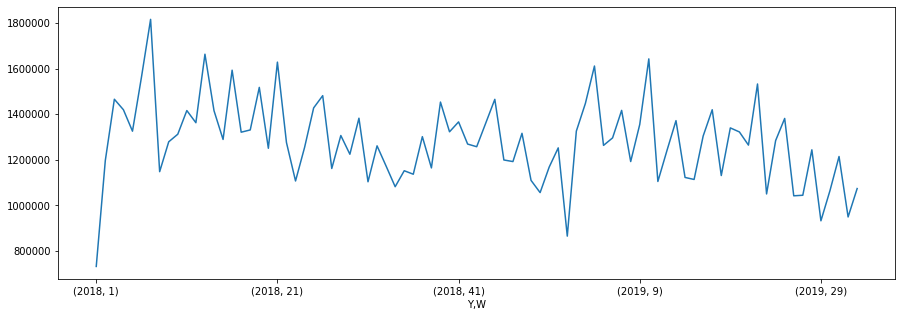

In [36]:
# Среднее значение продаж за неделю

weekly_mean_Delivered = sales[sales['train/test/fc'] == 'train/test'][['key', 'Y', 'W', 'Delivered']].groupby(['key', 'Y', 'W'], as_index=False).mean()
weekly_mean_Delivered.tail(100)
if len(weekly_mean_Delivered):
    weekly_mean_Delivered.groupby(['Y', 'W']).sum()['Delivered'].plot()

## Adding 'position_in_section'

In [37]:
# %%time
# sales['position_in_section'] = 0

# for key in sales.key.unique():
#     sample = sales[sales.key==key]

#     sample['count_after_promo'] = 0
#     sample['is_promoted'] = np.where(sample['Ship Discount on date'] > 0.0, True, False)

#     sample['inverted_is_promoted'] = ~sample['is_promoted']
#     sample['is_promoted_1'] = sample.is_promoted.shift(1)
#     sample['is_promoted_1'] = np.where(sample['is_promoted_1'].isna(), sample['inverted_is_promoted'], sample['is_promoted_1'])

#     sample['start_section'] = np.abs(sample['is_promoted'].astype(int) - sample['is_promoted_1'].astype(int))

#     section_starts = sample[sample.start_section == 1][['key', 'Date']]
#     section_starts['section_start_date'] = section_starts['Date']

#     sample = sample.merge(section_starts, how='left')
#     sample.fillna(method='ffill', inplace=True)

#     sample['position_in_section'] = sample[['key', 'Date', 'section_start_date']].groupby(['key', 'section_start_date'], as_index=False).cumcount()

#     sales.loc[sales['key'] == key, 'position_in_section'] = sample['position_in_section'].values

## Добавляем нумерацию дней от начала ship promo

In [38]:
# %%time
# sales['number start ship discount'] = 0

# for key in sales['key'].unique():
#     data = sales[sales['key'] == key].reset_index(drop=True)
    
#     for i in data.index.unique():
#         if i == 0 and data.loc[i, 'Ship Discount on date'] != 0:
#             j = 1
#             data.loc[i, 'number start ship discount'] = j
            
#         elif data.loc[i, 'Ship Discount on date'] != 0 and data.loc[i-1, 'Ship Discount on date'] != data.loc[i, 'Ship Discount on date']:
#             j = 1
#             data.loc[i, 'number start ship discount'] = j
            
#         elif data.loc[i, 'Ship Discount on date'] != 0 and data.loc[i-1, 'Ship Discount on date'] == data.loc[i, 'Ship Discount on date']:
#             j += 1
#             data.loc[i, 'number start ship discount'] = j
            
#     sales.loc[sales['key'] == key, 'number start ship discount'] = data['number start ship discount'].values    

## Добавляем нумерацию дней от начала stor promo

In [39]:
# %%time
# sales['number start stor discount'] = 0

# for key in sales['key'].unique():
#     data = sales[sales['key'] == key].reset_index(drop=True)
    
#     for i in data.index.unique():
#         if i == 0 and data.loc[i, 'Stor Discount on date'] != 0:
#             j = 1
#             data.loc[i, 'number start stor discount'] = j
            
#         elif data.loc[i, 'Stor Discount on date'] != 0 and data.loc[i-1, 'Stor Discount on date'] != data.loc[i, 'Stor Discount on date']:
#             j = 1
#             data.loc[i, 'number start stor discount'] = j
            
#         elif data.loc[i, 'Stor Discount on date'] != 0 and data.loc[i-1, 'Stor Discount on date'] == data.loc[i, 'Stor Discount on date']:
#             j += 1
#             data.loc[i, 'number start stor discount'] = j
            
#     sales.loc[sales['key'] == key, 'number start stor discount'] = data['number start stor discount'].values    

## добавляем старт промо

In [40]:
list(sales.columns)

['Date',
 'key',
 'Delivered',
 'Stor Discount on date',
 'Discount on date',
 'Promo_day_num',
 'PROMO_ID',
 'Y',
 'M',
 'W',
 'DoM',
 'DoW',
 'DoY',
 'HY',
 'Q',
 'S',
 'train/test/fc',
 'M_1',
 'M_2',
 'M_3',
 'M_4',
 'M_5',
 'M_6',
 'M_7',
 'M_8',
 'M_9',
 'M_10',
 'M_11',
 'M_12',
 'W_1',
 'W_2',
 'W_3',
 'W_4',
 'W_5',
 'W_6',
 'W_7',
 'W_8',
 'W_9',
 'W_10',
 'W_11',
 'W_12',
 'W_13',
 'W_14',
 'W_15',
 'W_16',
 'W_17',
 'W_18',
 'W_19',
 'W_20',
 'W_21',
 'W_22',
 'W_23',
 'W_24',
 'W_25',
 'W_26',
 'W_27',
 'W_28',
 'W_29',
 'W_30',
 'W_31',
 'W_32',
 'W_33',
 'W_34',
 'W_35',
 'W_36',
 'W_37',
 'W_38',
 'W_39',
 'W_40',
 'W_41',
 'W_42',
 'W_43',
 'W_44',
 'W_45',
 'W_46',
 'W_47',
 'W_48',
 'W_49',
 'W_50',
 'W_51',
 'W_52',
 'DoM_1',
 'DoM_2',
 'DoM_3',
 'DoM_4',
 'DoM_5',
 'DoM_6',
 'DoM_7',
 'DoM_8',
 'DoM_9',
 'DoM_10',
 'DoM_11',
 'DoM_12',
 'DoM_13',
 'DoM_14',
 'DoM_15',
 'DoM_16',
 'DoM_17',
 'DoM_18',
 'DoM_19',
 'DoM_20',
 'DoM_21',
 'DoM_22',
 'DoM_23',
 'DoM_24',

In [41]:
# sales['number start stor discount'] = 0

# for key in sales['key'].unique():
#     data = sales[sales['key'] == key].reset_index(drop=True)
    
#     for i in data.index.unique():
#         if i == 0 and data.loc[i, 'Stor Discount on date'] != 0:
#             j = 1
#             data.loc[i, 'number start stor discount'] = j
            
#         elif data.loc[i, 'Stor Discount on date'] != 0 and data.loc[i-1, 'Stor Discount on date'] != data.loc[i, 'Stor Discount on date']:
#             j = 1
#             data.loc[i, 'number start stor discount'] = j
            
#         elif data.loc[i, 'Stor Discount on date'] != 0 and data.loc[i-1, 'Stor Discount on date'] == data.loc[i, 'Stor Discount on date']:
#             j += 1
#             data.loc[i, 'number start stor discount'] = j
            
#     sales.loc[sales['key'] == key, 'number start stor discount'] = data['number start stor discount'].values    # Добавляем нумерацию дней от начала ship promo

# sales['number start ship discount'] = 0

# for key in sales['key'].unique():
#     data = sales[sales['key'] == key].reset_index(drop=True)
    
#     for i in data.index.unique():
#         if i == 0 and data.loc[i, 'Ship Discount on date'] != 0:
#             j = 1
#             data.loc[i, 'number start ship discount'] = j
            
#         elif data.loc[i, 'Ship Discount on date'] != 0 and data.loc[i-1, 'Ship Discount on date'] != data.loc[i, 'Ship Discount on date']:
#             j = 1
#             data.loc[i, 'number start ship discount'] = j
            
#         elif data.loc[i, 'Ship Discount on date'] != 0 and data.loc[i-1, 'Ship Discount on date'] == data.loc[i, 'Ship Discount on date']:
#             j += 1
#             data.loc[i, 'number start ship discount'] = j
            
#     sales.loc[sales['key'] == key, 'number start ship discount'] = data['number start ship discount'].values    

# # Добавляем нумерацию дней от начала stor promo

# # sales['number start stor discount'] = 0

# # for key in sales['key'].unique():
# #     data = sales[sales['key'] == key].reset_index(drop=True)
    
# #     for i in data.index.unique():
# #         if i == 0 and data.loc[i, 'Stor Discount on date'] != 0:
# #             j = 1
# #             data.loc[i, 'number start stor discount'] = j
            
# #         elif data.loc[i, 'Stor Discount on date'] != 0 and data.loc[i-1, 'Stor Discount on date'] != data.loc[i, 'Stor Discount on date']:
# #             j = 1
# #             data.loc[i, 'number start stor discount'] = j
            
# #         elif data.loc[i, 'Stor Discount on date'] != 0 and data.loc[i-1, 'Stor Discount on date'] == data.loc[i, 'Stor Discount on date']:
# #             j += 1
# #             data.loc[i, 'number start stor discount'] = j
            
# #     sales.loc[sales['key'] == key, 'number start stor discount'] = data['number start stor discount'].values    

In [42]:
# sales[sales['key'] == unique_positions[5]][['Discount on date', 'discount start']].head(1000)

In [43]:
# sales[sales['key'] == unique_positions[5]][['Discount on date', 'discount start', 'number start discount']].head(1000)

## добавляем лаг 3 к discount start

In [44]:
# sales.loc[sales['number start discount'] == 3, 'discount start lag 3'] = 1
# sales = sales.fillna(0)

In [45]:
# sales[sales['key'] == unique_positions[5]][['Discount on date', 'discount start lag 3', 'number start discount']].head(1000)

## дискаунт с затуханием

In [46]:
# sales['discount with attenuation'] = 0
# sales.loc[sales['Discount on date'] != 0, 'discount with attenuation'] = sales['Discount on date'] / sales['number start discount']

In [47]:
# sales[sales['key'] == unique_positions[5]][['Discount on date', 'discount with attenuation', 'number start discount']].head(1000)

## discount с лагом 3

In [48]:
# sales['Discount on date lag 3'] = 0

# for key in sales['key'].unique():
#     data = sales[sales['key'] == key].reset_index(drop=True)
#     data = data.reset_index()
    
#     discount_lag_plus_1 = data[['index', 'Discount on date']].copy()
#     discount_lag_plus_1['index'] = discount_lag_plus_1['index'] + 2
#     discount_lag_plus_1.rename(columns={'Discount on date': 'Discount on date lag plus 3'}, inplace=True)
    

#     data = data.merge(discount_lag_plus_1, how='left', left_on=['index'], right_on=['index'])


# #     data.drop(['index', 'Discount on date lag 1'], axis=1, inplace=True)
#     sales.loc[sales['key'] == key, 'Discount on date lag 3'] = data['Discount on date lag plus 3'].values

# sales = sales.fillna(0)


In [49]:
# sales[sales['key'] == unique_positions[5]][['Discount on date', 'discount start']].head(1000)

## discount с лагом и затуханием

In [50]:
# sales['Discount attenuation lag 3'] = 0

# for key in sales['key'].unique():
#     data = sales[sales['key'] == key].reset_index(drop=True)
#     data = data.reset_index()
    
#     discount_lag_plus_1 = data[['index', 'Discount on date', 'number start discount']].copy()
#     discount_lag_plus_1['index'] = discount_lag_plus_1['index'] + 2
#     discount_lag_plus_1['Discount on date'] = discount_lag_plus_1['Discount on date'] / discount_lag_plus_1['number start discount']
#     discount_lag_plus_1.rename(columns={'Discount on date': 'Discount on attenuation lag plus 3'}, inplace=True)
    

#     data = data.merge(discount_lag_plus_1, how='left', left_on=['index'], right_on=['index'])


# #     data.drop(['index', 'Discount on date lag 1'], axis=1, inplace=True)
#     sales.loc[sales['key'] == key, 'Discount attenuation lag 3'] = data['Discount on attenuation lag plus 3'].values

# sales = sales.fillna(0)

In [51]:
# sales[sales['key'] == unique_positions[5]][['Discount on date', 'Discount attenuation lag 3']].head(1000)

## Number start discount векторизация

In [52]:
# # ds
# sales['number start stor discount'] = np.where(sales['number start stor discount'] < 90, sales['number start stor discount'], -1)

# sales = conversion_add_get_dummies(sales, ['number start stor discount'])



In [53]:
# sales['number start stor discount'].max()

## "Is_day_before_promo_ship"

In [54]:
# # TODO: Fix it. it doesn't work properly
# # sales['Day_before_promo'] = sales[['key', 'Date', 'number start ship discount']].groupby(['key', 'Date'], as_index=False).first()['number start ship discount'].shift(-1)
# # sales['Day_before_promo'] = sales['Day_before_promo'].fillna(0) 
# # sales['Day_before_promo'] = np.where(sales['Day_before_promo'] > 1, 0, sales['Day_before_promo'])

# sales['is_day_before_promo_ship'] = 0
# for key in sales.key.unique():
    
#     s = sales[sales.key==key]['number start ship discount']
#     s = s.shift(-1, fill_value=0)
#     s = np.where(s > 1, 0, s)
#     sales.loc[sales.key==key, 'is_day_before_promo_ship'] = s
    
    

# Models

In [55]:
from collections import namedtuple

In [56]:
ModelPoolItem = namedtuple('ModelPoolItem', ['model_name', 'params', 'constructor', 'features'], )

In [57]:
class FBProphet_sklearn():
    
    def __init__(self, y_column, date_column, regressor_columns, prophet_params=None):
        self.y_column = y_column
        self.date_column = date_column
        self.regressor_columns = regressor_columns
        self.prophet_params = prophet_params if prophet_params is not None else dict()
    
    def add_regressor(self):
        if self.regressor_columns != []:
            for column_name in self.regressor_columns:
                self.prophet.add_regressor(column_name)
    
    def fit(self, X, y):
        self.prophet = Prophet(**self.prophet_params)
        self.add_regressor()
        
        X['y'] = y
        df = X.copy()
        df = df.rename(columns={self.date_column: 'ds'}).reset_index(drop=True)
        
        self.prophet.fit(df)
        
    def predict(self, X):
        df = X.rename(columns={self.date_column: 'ds'}).reset_index(drop=True)
        return self.prophet.predict(df)['yhat'].values
        

In [58]:
# NN_x_windth = 30  # TODO: automate this definition
# NN_EPOCHS = 400
# def build_fn(startlr=0.01, decayrate=2, l1reg=0.001):
    
#     model = keras.Sequential()
#     model.add(keras.layers.Dense(200, activation=tf.nn.relu,
#                        input_shape=(NN_x_windth,), kernel_regularizer=l1(l1reg)))
#     model.add(keras.layers.Dense(50, activation=tf.nn.relu, kernel_regularizer=l1(l1reg)))
#     model.add(keras.layers.Dense(1))

#     optimizer=keras.optimizers.Adam(lr=startlr,  decay=startlr/(decayrate))
#     model.compile(loss='mae',
#                 optimizer=optimizer,
#                 metrics=['mae'])
#     return model


In [59]:
# class ScaledKerasRegressor(KerasRegressor):
#     # TODO: automate defining set of available columns
#     columns_x = [
# #         'cpf',
#         'M','Q','Y','W','Holidays','index',
        
#         'PLAN_INVEST',              
#         'dbscan_outlier',
        
#         'lag_1_PLAN_INVEST',
#         'dbscan_outlier_lag_1',

#         'lag_2_PLAN_INVEST',
#         'dbscan_outlier_lag_2',

# #         'lag_3_PLAN_INVEST',
# #         'dbscan_outlier_lag_3',

#         'dbscan_outlier_lag_m1',
#         ]
    
#     # DANGERIOUS! two next variables linked
#     columns_to_dummy = ['M', 'Q', 'Holidays']
#     dummy_columns = set(['M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 'M_10', 'M_11', 'M_12', \
#                         'Q_1', 'Q_2', 'Q_3', 'Q_4', \
#                         'Holidays_0', 'Holidays_1', 'Holidays_2', 'Holidays_3'])
    
#     @staticmethod
#     def get_dummies(df):
        
#         for column in ScaledKerasRegressor.columns_to_dummy:
#             df[column] = df[column].astype('str')
#         dummied_df = pd.get_dummies(df)
#         missed_dummy_columns = list(ScaledKerasRegressor.dummy_columns - set(dummied_df.columns))
#         for col in missed_dummy_columns:
#             dummied_df[col] = 0
        
#         return dummied_df
        
    
#     def __init__(self, build_fn=None, x_width=0, **kwargs):
        
#         super().__init__(build_fn=build_fn, **kwargs)
#         self.scaler_x = None
#         self.scaler_y = None
#         self.fit_columns = None
    
#     def fit(self, x, y, *args,  **kwargs):
#         x = x[ScaledKerasRegressor.columns_x]
#         x = ScaledKerasRegressor.get_dummies(x)
#         self.fit_columns = x.columns        
        
#         self.scaler_x = MinMaxScaler(feature_range=(0, 1))
#         x = self.scaler_x.fit_transform(x)
#         x = pd.DataFrame(x, columns=self.fit_columns)

#         self.scaler_y = MinMaxScaler(feature_range=(0, 1))
#         y = self.scaler_y.fit_transform(y.values.reshape(-1, 1)) # .reshape(-1, 1)
        
#         return super().fit(x, y, **kwargs)
    
#     def predict(self, x, **kwargs):
#         x = x[ScaledKerasRegressor.columns_x]
#         x = ScaledKerasRegressor.get_dummies(x)
#         columns = x.columns    

#         if (len(self.fit_columns) != len(columns)) or (set(self.fit_columns) != set(columns)): 
#             missed_columns = list(set(self.fit_columns) - set(columns))
#             for col in missed_columns:
#                 x[col] = 0
        
#         x = self.scaler_x.fit_transform(x)
#         x = pd.DataFrame(x, columns=columns)        
                
#         prediction = super().predict(x, **kwargs)
#         prediction = self.scaler_y.inverse_transform(prediction.reshape(-1, 1))
        
#         return prediction

In [60]:
sales.columns

Index(['Date', 'key', 'Delivered', 'Stor Discount on date', 'Discount on date',
       'Promo_day_num', 'PROMO_ID', 'Y', 'M', 'W',
       ...
       'cos(DoW)', 'sin(DoW)', 'cos(Q)', 'sin(Q)', 'cos(S)', 'sin(S)',
       'cos(HY)', 'sin(HY)', 'cos(DoY)', 'sin(DoY)'],
      dtype='object', length=145)

In [61]:
TARGET_COLUMN = 'Delivered'

# все колонки оутлаеров должны быть проигнорированы для thf
DROP_COLUMNS = ['key', 'train/test/fc']
FEATURES = [col for col in sales.columns if col not in DROP_COLUMNS] 
FEATURES.remove(TARGET_COLUMN)


In [62]:
FEATURES

['Date',
 'Stor Discount on date',
 'Discount on date',
 'Promo_day_num',
 'PROMO_ID',
 'Y',
 'M',
 'W',
 'DoM',
 'DoW',
 'DoY',
 'HY',
 'Q',
 'S',
 'M_1',
 'M_2',
 'M_3',
 'M_4',
 'M_5',
 'M_6',
 'M_7',
 'M_8',
 'M_9',
 'M_10',
 'M_11',
 'M_12',
 'W_1',
 'W_2',
 'W_3',
 'W_4',
 'W_5',
 'W_6',
 'W_7',
 'W_8',
 'W_9',
 'W_10',
 'W_11',
 'W_12',
 'W_13',
 'W_14',
 'W_15',
 'W_16',
 'W_17',
 'W_18',
 'W_19',
 'W_20',
 'W_21',
 'W_22',
 'W_23',
 'W_24',
 'W_25',
 'W_26',
 'W_27',
 'W_28',
 'W_29',
 'W_30',
 'W_31',
 'W_32',
 'W_33',
 'W_34',
 'W_35',
 'W_36',
 'W_37',
 'W_38',
 'W_39',
 'W_40',
 'W_41',
 'W_42',
 'W_43',
 'W_44',
 'W_45',
 'W_46',
 'W_47',
 'W_48',
 'W_49',
 'W_50',
 'W_51',
 'W_52',
 'DoM_1',
 'DoM_2',
 'DoM_3',
 'DoM_4',
 'DoM_5',
 'DoM_6',
 'DoM_7',
 'DoM_8',
 'DoM_9',
 'DoM_10',
 'DoM_11',
 'DoM_12',
 'DoM_13',
 'DoM_14',
 'DoM_15',
 'DoM_16',
 'DoM_17',
 'DoM_18',
 'DoM_19',
 'DoM_20',
 'DoM_21',
 'DoM_22',
 'DoM_23',
 'DoM_24',
 'DoM_25',
 'DoM_26',
 'DoM_27',
 'DoM_

In [63]:
# OPTIMAL_PARAMS_MODELS.head(1)

In [64]:
def add_optimal_models(pool):
    params_tree = {'booster': 'gbtree'}
    features = []
    
    pool_item = ModelPoolItem(model_name='xgb_tree_optimal_date_simple', params=params_tree, 
                              constructor=xgb.XGBRegressor, features=features)    
    pool.append(pool_item)
    
#     pool_item = ModelPoolItem(model_name='xgb_tree_optimal_date_vectors', params=params_tree, 
#                               constructor=xgb.XGBRegressor, features=features)    
#     pool.append(pool_item)
    
#     pool_item = ModelPoolItem(model_name='xgb_tree_optimal_date_sin_cos', params=params_tree, 
#                               constructor=xgb.XGBRegressor, features=features)    
#     pool.append(pool_item)
    
    return pool

In [65]:
number_start_discount_vectors = [col for col in sales.columns if 'number start discount_' in col]
number_start_discount_vectors

[]

In [66]:
date_simple = ['Y', 'M', 'W', 'DoM', 'DoW', 'DoY', 'Q', 'S', 'HY']
date_vectors = [col for col in sales.columns if 'Y_' in col or 'M_' in col or 'W_' in col or 'DoM_' in col \
               or 'DoW_' in col or 'Q_' in col or 'S_' in col or 'HY_' in col] + ['DoY']
date_sin_cos = [col for col in sales.columns if ('sin' in col) or ('cos' in col)]

FEATURES_SIMPLE = ['Stor Discount on date', 'Ship Discount on date', 'number start stor discount', 
                   'number start ship discount'] + date_simple

FEATURES_VECTORS = ['Stor Discount on date', 'Ship Discount on date'] + date_vectors

FEATURES_SIN_COS = ['Stor Discount on date', 'Ship Discount on date', 'number start stor discount', 
                   'number start ship discount'] + date_sin_cos

# DOP_FEATURES = ['number start discount', 'discount with attenuation', 'Discount attenuation lag 3']

### FBProphet_Advanced_sklearn

In [67]:
class FBProphet_Advanced_sklearn():
    """
    Assumptions
        X sorted by Date
        
    """
    @staticmethod
    def add_start_end_distance(df, column_name, lags=None):
        lags = [1, 2, 3] if lags is None else lags
        
        df['to_del_start'] = (np.diff(df[column_name].values, prepend=0) == 1)*1
        df['to_del_end'] = (np.diff(df[column_name].values, prepend=0) == -1)*1

        columns = []
        for i in lags:
            df[f'{column_name}_Promo_{i}'] = df['to_del_start'].shift(i-1)
            df[f'{column_name}_After_{i}'] = df['to_del_end'].shift(i-1)
            
            columns.append(f'{column_name}_Promo_{i}')
            columns.append(f'{column_name}_After_{i}')

        df.drop(columns=['to_del_end', 'to_del_start'], inplace=True)
        df.fillna(0, inplace=True) 
        
        return columns 
    
    @staticmethod
    def preprocess(df):
        distance_cols = FBProphet_Advanced_sklearn.add_start_end_distance(df, column_name='Ship Discount on date')
        
        df['week_day'] = df['ds'].dt.weekday
                
        df['discount'] = df['Ship Discount on date']
        
        no_promo_cols = []
        for dow in range(0, 7):
            col = f'no_promo_{dow}'
            df[col] = np.where(df['Ship Discount on date'] > 0, 0, 1) * (df['week_day']==dow)
            
            no_promo_cols.append(col)
            
        final_columns = distance_cols + ['week_day', 'discount'] + no_promo_cols
        return final_columns
        
        
    # seasonality_mode='multiplicative'
    def __init__(self, y_column, date_column, regressor_columns, prophet_params=None):
        self.y_column = y_column
        self.date_column = date_column
        self.regressor_columns = regressor_columns        
        self.prophet_params = prophet_params if prophet_params is not None else dict()
      
    def add_regressor(self):
        if self.regressor_columns != []:
            for column_name in self.regressor_columns:
                self.prophet.add_regressor(column_name)
    
    def fit(self, X, y):
        
        X['y'] = y
        df = X.copy()
        df = df.rename(columns={self.date_column: 'ds'}).reset_index(drop=True)

        regressor_columns = FBProphet_Advanced_sklearn.preprocess(df)
        self.regressor_columns = regressor_columns
        
        # ['Delivered', 'Date', 'Ship. Promo on date', 'Discount on date']
        self.prophet = Prophet(**self.prophet_params)
        self.prophet.add_country_holidays(country_name='RU')
        self.add_regressor()        
        
        self.prophet.fit(df)
        
    def predict(self, X):
               
        df = X.rename(columns={self.date_column: 'ds'}).reset_index(drop=True)
        FBProphet_Advanced_sklearn.preprocess(df)
        return self.prophet.predict(df)['yhat'].values
        

### FBProphet_Advanced_sklearn_PP

In [68]:
class FBProphet_Advanced_sklearn_PP():
    """
    Assumptions
        X sorted by Date
        
    """
    @staticmethod
    def add_start_end_distance(df, column_name, lags=None):
        lags = [1, 2, 3] if lags is None else lags
        
        df['to_del_start'] = (np.diff(df[column_name].values, prepend=0) == 1)*1
        df['to_del_end'] = (np.diff(df[column_name].values, prepend=0) == -1)*1

        columns = []
        for i in lags:
            df[f'{column_name}_Promo_{i}'] = df['to_del_start'].shift(i-1)
            df[f'{column_name}_After_{i}'] = df['to_del_end'].shift(i-1)
            
            columns.append(f'{column_name}_Promo_{i}')
            columns.append(f'{column_name}_After_{i}')

        df.drop(columns=['to_del_end', 'to_del_start'], inplace=True)
        df.fillna(0, inplace=True) 
        
        return columns 
    
    @staticmethod
    def preprocess(df):
        distance_cols = FBProphet_Advanced_sklearn.add_start_end_distance(df, column_name='Ship Discount on date')
        
        df['week_day'] = df['ds'].dt.weekday
                
        df['discount'] = df['Ship Discount on date']
        
        no_promo_cols = []
        for dow in range(0, 7):
            col = f'no_promo_{dow}'
            df[col] = np.where(df['Ship Discount on date'] > 0, 0, 1) * (df['week_day']==dow)
            
            no_promo_cols.append(col)
            
        final_columns = distance_cols + ['week_day', 'discount'] + no_promo_cols
        return final_columns
        
        
    # seasonality_mode='multiplicative'
    def __init__(self, y_column, date_column, regressor_columns, prophet_params=None):
        self.y_column = y_column
        self.date_column = date_column
        self.regressor_columns = regressor_columns        
        self.prophet_params = prophet_params if prophet_params is not None else dict()
      
    def add_regressor(self):
        if self.regressor_columns != []:
            for column_name in self.regressor_columns:
                self.prophet.add_regressor(column_name)
    
    def fit(self, X, y):
        
        X['y'] = y
        df = X.copy()
        df = df.rename(columns={self.date_column: 'ds'}).reset_index(drop=True)        
        
        regressor_columns = FBProphet_Advanced_sklearn.preprocess(df)
        self.regressor_columns = regressor_columns

        #  promo profile adding ->
        self.PP = df.groupby(['number start ship discount'], 
           as_index=False).agg({'y': 'mean'}).rename(columns={'y': 'Profile Promo'})

        df = df.merge(self.PP, how='left', 
                            left_on=['number start ship discount'], 
                            right_on=['number start ship discount']).fillna(0)
        # <- promo profile adding
        self.regressor_columns.append('Profile Promo')
        
        # ['Delivered', 'Date', 'Ship. Promo on date', 'Discount on date']
        self.prophet = Prophet(**self.prophet_params)
        self.prophet.add_country_holidays(country_name='RU')
        self.add_regressor()        
        
        self.prophet.fit(df)
        
    def predict(self, X):
               
        df = X.rename(columns={self.date_column: 'ds'}).reset_index(drop=True)
        FBProphet_Advanced_sklearn.preprocess(df)
        
        #  promo profile adding ->
        df = df.merge(self.PP, how='left', 
                            left_on=['number start ship discount'], 
                            right_on=['number start ship discount']).fillna(0)
        # <- promo profile adding        
        
        return self.prophet.predict(df)['yhat'].values
        

### Art_XGB

In [69]:
TMP = None

In [70]:
# TODO: переписать понятно простым смертным
# Note: чувствительна к выбору периода - использует недельные данные, для BL

class Art_XGB():
    @staticmethod
    def CustCV(dataSampleBaseTrain):
        if (len(dataSampleBaseTrain) < 17) or (dataSampleBaseTrain['Delivered'].sum() == 0):
            return 30

        tscv = TimeSeriesSplit(n_splits=15)
        ress = pd.DataFrame()
        
        indexes = list(tscv.split(dataSampleBaseTrain))[10:]
       
        for train_index, test_index in indexes:
                
            Xtrain = dataSampleBaseTrain.iloc[train_index].drop(columns=['Delivered'])
            ytrain = dataSampleBaseTrain.iloc[train_index]['Delivered']
            Xtest = dataSampleBaseTrain.iloc[test_index].drop(columns=['Delivered'])
            ytest = dataSampleBaseTrain.iloc[test_index]['Delivered']                

            for estimator in [3, 10, 30, 50, 80, 100, 150, 200]:
                reg = GradientBoostingRegressor(n_estimators=estimator, max_depth=2, learning_rate=0.1,
                                                         verbose=False)  # ,n_iter_no_change=15,validation_fraction=0.05)
                reg.fit(Xtrain, ytrain)

                ress = ress.append(
                    [[estimator, (1 - np.sum(abs(ytest - reg.predict(Xtest))) / np.sum(ytest))]])
        ressg = ress.groupby(0).mean()
        return ressg[1].idxmax()
    
    def __init__(self):
        self.reg_base = None
        self.reg_full = None
        
    def fit(self, X, y):
        
        bl_df = pd.DataFrame.copy(X)
        bl_df['Delivered'] = y
        bl_df = bl_df[bl_df['Ship Discount on date'] == 0]
   
        weekly_bl_df = bl_df.groupby(['Y', 'W'], as_index=False).mean()
        n_estimators = Art_XGB.CustCV(weekly_bl_df)
        self.reg_base = GradientBoostingRegressor(n_estimators=n_estimators, 
                                                  max_depth=2, 
                                                  learning_rate=0.1, 
                                                  verbose=False)
        self.reg_base.fit(weekly_bl_df.drop(columns=['Delivered']), weekly_bl_df['Delivered'])
        
        full_df_x = pd.DataFrame.copy(X)
        for i in range(-20,20,1):
            full_df_x['disc-' + str(i)] = full_df_x['Ship Discount on date'].shift(i).fillna(0)
        self.reg_full = GradientBoostingRegressor(n_estimators = 80, max_depth = 2,learning_rate = 0.1, verbose = False)
        self.reg_full.fit(full_df_x, y)
        
        self.DoW_bl_profile = bl_df[['DoW', 'Delivered']].groupby('DoW', as_index=False).sum()
        self.DoW_bl_profile.rename(columns={'Delivered': 'DoW_bl_profile'}, inplace=True)
    
    def predict(self, X):
        
        # get_bl
        weekly_x = X.groupby(['Y', 'W'], as_index=False).mean()
        weekly_x['bl'] = self.reg_base.predict(weekly_x)
        bl = X.merge(weekly_x[['Y', 'W', 'bl']], )['bl'].values

        # get full fc 
        full_df_x = pd.DataFrame.copy(X)
        for i in range(-20,20,1):
            full_df_x['disc-' + str(i)] = full_df_x['Ship Discount on date'].shift(i).fillna(0)
        full_fc = self.reg_full.predict(full_df_x)
        
        # return np.where(X['Ship Discount on date'] == 0, bl, full_fc)

        # TODO: move to func
        
        
        results = X.copy()
        results['pred'] = bl
        results['pred_promo'] = full_fc
        
        resultsbase = results[results['Ship Discount on date'] == 0]
        resultsbase['Weeksum'] = resultsbase.groupby(['Y','W'])['pred'].transform('sum')
        resultsbase['Weekpromo'] = resultsbase.groupby(['Y','W'])['pred_promo'].transform('sum')
        resultsbase['base_corrected'] = resultsbase['pred_promo'] * resultsbase['Weeksum'] / resultsbase['Weekpromo']
        
        resultsbase = resultsbase[['Y', 'DoY', 'base_corrected']]
        
        results = results.merge(resultsbase, how = 'left')
        results['pred_ens2'] = np.where(results['Ship Discount on date'] == 0, results['base_corrected'], results['pred_promo'])
        
#         results['Weeksum'] = results.groupby(['Y','W'])['pred'].transform('sum')
#         results['Weekpromo'] = results.groupby(['Y','W'])['pred_promo'].transform('sum')

#         results['base_corrected'] = results['pred_promo'] * results['Weeksum'] / results['Weekpromo']
#         results['pred_ens2'] = np.where(results['Ship Discount on date'] > 0, results['pred_promo'], results['base_corrected'])

        # ds
        self.DoW_bl_profile['DoW_Ratio'] = self.DoW_bl_profile['DoW_bl_profile'] / self.DoW_bl_profile['DoW_bl_profile'].sum()
        results = results.merge(self.DoW_bl_profile, how ='left')
        
        results['bl_ds'] = results['DoW_Ratio'] * results['pred']
        results['pred_ds_3'] = np.where(results['Ship Discount on date'] == 0, results['bl_ds'], results['pred_promo'])
        
        
        
        global TMP
        TMP = results
        
#         return results['pred_ens2'].values
        return results['pred_ds_3'].values
    
    
#         results['DoW_BL_profile'] = results.groupby('DoW')[]


In [71]:
TMP

### XGB_PP

In [72]:
class XGB_PP(xgb.XGBRegressor):
    
    def fit(self, X, y):
        
        X['y'] = y
        self.PP = X.groupby(['number start ship discount'], 
                       as_index=False).agg({'y': 'mean'}).rename(columns={'y': 'Profile Promo'})
#         self.DOW_profile = X.groupby('DoW', as_index=False).agg({'y':'mean'})
        
        
        X = X.merge(self.PP, how='left', left_on=['number start ship discount'], 
                    right_on=['number start ship discount']).drop('y', axis=1).fillna(0)
#         X = X.merge(self.DOW_profile, how='left', left_on=['DoW'], right_on=['DoW'])
        
        
        max_value = self.PP['Profile Promo'].max()
        self.max_value_pp_day = self.PP[self.PP['Profile Promo'] == max_value]['number start ship discount'].values[0]
        X['is_max_value_pp_day'] = np.where(X['number start ship discount'] == self.max_value_pp_day, 1, 0)
        
        super().fit(X, y)
        
    def predict(self, X):
        
        X = X.merge(self.PP, how='left', left_on=['number start ship discount'], 
                    right_on=['number start ship discount']).fillna(0)
#         X = X.merge(self.DOW_profile, how='left', left_on=['DoW'], right_on=['DoW'])

        X['is_max_value_pp_day'] = np.where(X['number start ship discount'] == self.max_value_pp_day, 1, 0)
        
        return super().predict(X)

### XGB_PP_APP

In [73]:
class XGB_PP_APP(xgb.XGBRegressor):
    
    def fit(self, X, y):
        
        X['y'] = y
        self.PP = X.groupby(['number start ship discount'], 
                       as_index=False).agg({'y': 'mean'}).rename(columns={'y': 'Profile Promo'})
#         self.DOW_profile = X.groupby('DoW', as_index=False).agg({'y':'mean'})

        gr = X[(X['Ship Discount on date'] == 0.0) & (X['position_in_section'] < 7)].groupby('position_in_section', as_index=False)
        self.APP = gr.agg({'y': 'mean'}).rename(columns={'y': 'After Promo Profile'})
        
        X = X.merge(self.PP, how='left', left_on=['number start ship discount'], 
                    right_on=['number start ship discount']).drop('y', axis=1).fillna(0)
#         X = X.merge(self.DOW_profile, how='left', left_on=['DoW'], right_on=['DoW'])
        
        X = X.merge(self.APP, how='left', left_on=['position_in_section'], 
                    right_on=['position_in_section']).fillna(0)
        
        max_value = self.PP['Profile Promo'].max()
        self.max_value_pp_day = self.PP[self.PP['Profile Promo'] == max_value]['number start ship discount'].values[0]
        X['is_max_value_pp_day'] = np.where(X['number start ship discount'] == self.max_value_pp_day, 1, 0)
        
        super().fit(X, y)
        
    def predict(self, X):
        
        X = X.merge(self.PP, how='left', left_on=['number start ship discount'], 
                    right_on=['number start ship discount']).fillna(0)
        # X = X.merge(self.DOW_profile, how='left', left_on=['DoW'], right_on=['DoW'])
        X = X.merge(self.APP, how='left', left_on=['position_in_section'], 
                    right_on=['position_in_section']).fillna(0)
        
        X['is_max_value_pp_day'] = np.where(X['number start ship discount'] == self.max_value_pp_day, 1, 0)
        
        return super().predict(X)

### Models pool

In [74]:
def models_pool():
    
    pool = []
    
#     #  prophets ->
#     prophet_features = [
#         'Date',
#         'Ship Discount on date',
#         'number start ship discount',
#          ]
#     prophet_params = {'y_column': 'Delivered', 'date_column': 'Date', 'regressor_columns': ['Ship Discount on date']}
#     pool_item = ModelPoolItem(model_name='fbprophet_advanced_pp', params=prophet_params, 
#                               constructor=FBProphet_Advanced_sklearn_PP, features=prophet_features)    
#     pool.append(pool_item)
    
#     pool_item = ModelPoolItem(model_name='fbprophet_advanced', params=prophet_params, 
#                               constructor=FBProphet_Advanced_sklearn, features=prophet_features)    
#     pool.append(pool_item)
#     # <- prophets
    
#     #  XGB_PP ->
#     params_tree = {'reg_lambda': 3,
#                      'objective': 'reg:squarederror',
#                      'n_estimators': 30,
#                      'max_depth': 7,
#                      'criterion': 'mse',
#                      'booster': 'gbtree',
#                       'learning_rate':0.3,
#                                      }  
    
#     features = [f for f in FEATURES_SIMPLE if 'stor' not in f.lower()] + ['is_day_before_promo_ship', 'position_in_section']
#     pool_item = ModelPoolItem(model_name='xgb_tree_features_simple_pp', params=params_tree, 
#                               constructor=XGB_PP, features=features)    

#     pool.append(pool_item)
#     # <- XGB_PP
    
#     #  XGB_PP_APP ->
#     params_tree = {'reg_lambda': 3,
#                      'objective': 'reg:squarederror',
#                      'n_estimators': 30,
#                      'max_depth': 7,
#                      'criterion': 'mse',
#                      'booster': 'gbtree',
#                       'learning_rate':0.3,
#                                      }  
    
#     features = [f for f in FEATURES_SIMPLE if 'stor' not in f.lower()] + ['is_day_before_promo_ship', 'position_in_section']
#     pool_item = ModelPoolItem(model_name='xgb_tree_features_simple_pp_app', params=params_tree, 
#                               constructor=XGB_PP_APP, features=features)    

#     pool.append(pool_item)
#     # <- XGB_PP_APP
    
    
    # ART XGB
    # features = [f for f in FEATURES_SIMPLE if 'stor' not in f.lower()] + ['is_day_before_promo_ship', 'position_in_section']
    features = ['Ship Discount on date', 
                'Y', 'M', 'W', 'DoM', 'DoW', 
                'DoY', 'Q', 'S', 'HY', 'is_day_before_promo_ship', 'position_in_section']
    pool_item = ModelPoolItem(model_name='art_xgb', params={}, 
                              constructor=Art_XGB, features=features)    

    pool.append(pool_item)
    # ART XGB
    return pool

MODELS_POOL = models_pool()


In [75]:
for item in MODELS_POOL:
    print(item, '\n')

ModelPoolItem(model_name='art_xgb', params={}, constructor=<class '__main__.Art_XGB'>, features=['Ship Discount on date', 'Y', 'M', 'W', 'DoM', 'DoW', 'DoY', 'Q', 'S', 'HY', 'is_day_before_promo_ship', 'position_in_section']) 



In [76]:
best_models = pd.DataFrame(columns=['cpf', 'model_name', 'model'])

In [77]:
sorted(FEATURES)

['Date',
 'Discount on date',
 'DoM',
 'DoM_1',
 'DoM_10',
 'DoM_11',
 'DoM_12',
 'DoM_13',
 'DoM_14',
 'DoM_15',
 'DoM_16',
 'DoM_17',
 'DoM_18',
 'DoM_19',
 'DoM_2',
 'DoM_20',
 'DoM_21',
 'DoM_22',
 'DoM_23',
 'DoM_24',
 'DoM_25',
 'DoM_26',
 'DoM_27',
 'DoM_28',
 'DoM_29',
 'DoM_3',
 'DoM_30',
 'DoM_31',
 'DoM_4',
 'DoM_5',
 'DoM_6',
 'DoM_7',
 'DoM_8',
 'DoM_9',
 'DoW',
 'DoW_0',
 'DoW_1',
 'DoW_2',
 'DoW_3',
 'DoW_4',
 'DoW_5',
 'DoW_6',
 'DoY',
 'HY',
 'HY_1',
 'HY_2',
 'M',
 'M_1',
 'M_10',
 'M_11',
 'M_12',
 'M_2',
 'M_3',
 'M_4',
 'M_5',
 'M_6',
 'M_7',
 'M_8',
 'M_9',
 'PROMO_ID',
 'Promo_day_num',
 'Q',
 'Q_1',
 'Q_2',
 'Q_3',
 'Q_4',
 'S',
 'S_1',
 'S_2',
 'S_3',
 'S_4',
 'Stor Discount on date',
 'W',
 'W_1',
 'W_10',
 'W_11',
 'W_12',
 'W_13',
 'W_14',
 'W_15',
 'W_16',
 'W_17',
 'W_18',
 'W_19',
 'W_2',
 'W_20',
 'W_21',
 'W_22',
 'W_23',
 'W_24',
 'W_25',
 'W_26',
 'W_27',
 'W_28',
 'W_29',
 'W_3',
 'W_30',
 'W_31',
 'W_32',
 'W_33',
 'W_34',
 'W_35',
 'W_36',
 'W_37',

In [78]:
sales.columns

Index(['Date', 'key', 'Delivered', 'Stor Discount on date', 'Discount on date',
       'Promo_day_num', 'PROMO_ID', 'Y', 'M', 'W',
       ...
       'cos(DoW)', 'sin(DoW)', 'cos(Q)', 'sin(Q)', 'cos(S)', 'sin(S)',
       'cos(HY)', 'sin(HY)', 'cos(DoY)', 'sin(DoY)'],
      dtype='object', length=145)

In [79]:
OUTCOME_COLUMNS = [
    'Date',
    'key',
    'best_model_name',
    'train/test/fc', 
#     'Discount on date', 
    'Delivered',
#     'Ship. Promo on date', 
#     'Stor. Promo on date', 
    #'service',
    'Y',
    'W',
    
]  + ['THF_CUSTOM', ]
print(OUTCOME_COLUMNS)
outcome = pd.DataFrame(columns=OUTCOME_COLUMNS)

['Date', 'key', 'best_model_name', 'train/test/fc', 'Delivered', 'Y', 'W', 'THF_CUSTOM']


In [80]:
MODELS_COLUMNS = [tp + model for model, *_ in MODELS_POOL for tp in ['thf_',]]
EXTENDED_OUTCOME_COLUMNS = OUTCOME_COLUMNS + MODELS_COLUMNS

In [81]:
EXTENDED_OUTCOME_COLUMNS

['Date',
 'key',
 'best_model_name',
 'train/test/fc',
 'Delivered',
 'Y',
 'W',
 'THF_CUSTOM',
 'thf_art_xgb']

In [82]:
extended_outcome = pd.DataFrame(columns=EXTENDED_OUTCOME_COLUMNS)

In [83]:
from sklearn.metrics import mean_absolute_error as mae

In [84]:
from sklearn.model_selection import cross_validate

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [86]:
from sklearn.model_selection import train_test_split
CV_RATIOS = [0.5, 0.6, 0.7, 0.8, 0.9, ]

# Functions

In [87]:
def custom_score(y_act, y_act_pred):
#     print('custom_score')
#     print(y_act)
#     print(y_act_pred)
    y_act = np.array(y_act)
    
    y_act_pred = np.array(y_act_pred)
    
    quant_day_acts = len(y_act)    
    results = []
    
    for week in range(0, quant_day_acts, 7):
        
        act = y_act[week:(week+7)].sum()
        fc = y_act_pred[week:(week+7)].sum()
        
        if  act == 0 and fc == 0:
            fa = 1
        elif act == 0:
            fa = 0
        else:
            AE = np.abs(act - fc)
            fa = 1 - AE.sum() / act
            
        results.append(fa)
#         print('act', act, 'fc', fc, 'fa', fa)
    
    return np.mean(results)

In [88]:

def custom_ts_cross_val_score(model, data_x, data_y, model_name, cv_ratios, n_splits=5):
    # DEBUG
#     print(data_x.columns)
    global TMP
    TMP = (model, data_x, data_y, model_name,)
    
    results = []
    
    for i in range(n_splits):
        
        step_len = 7
        if len(data_y) > (step_len * n_splits):
            
            test_start = -(step_len * (n_splits - i))
            test_end = -(step_len * (n_splits - i - 1))

            X_train = data_x[0:test_start]
            y_train = data_y[0:test_start]

            X_test = data_x[test_start: (test_end if test_end != 0 else None)]
            y_test = data_y[test_start: (test_end if test_end != 0 else None)]
            
        else:
            continue            

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # results.append(-1 * mae(y_test, y_pred))
        results.append(custom_score(y_test, y_pred))
    
    return results


In [89]:
def init_optinal_model(key, model_name, models, constructor):
    if key not in OPTIMAL_PARAMS_MODELS.index:
        return models
    
    if model_name == 'xgb_tree_optimal_date_simple':
        params = eval(OPTIMAL_PARAMS_MODELS.loc[key, 'best_params_tree_simple'])
        features = eval(OPTIMAL_PARAMS_MODELS.loc[key, 'features_tree_simple'])
        
        model = constructor(**params)
        models.append((model_name, model, features))
        
    elif model_name == 'xgb_tree_optimal_date_vectors':
        params = eval(OPTIMAL_PARAMS_MODELS.loc[key, 'best_params_tree_vectors'])
        features = eval(OPTIMAL_PARAMS_MODELS.loc[key, 'features_tree_vectors'])
        
        model = constructor(**params)
        models.append((model_name, model, features))
        
    elif model_name == 'xgb_tree_optimal_date_sin_cos':
        params = eval(OPTIMAL_PARAMS_MODELS.loc[key, 'best_params_tree_sin_cos'])
        features = eval(OPTIMAL_PARAMS_MODELS.loc[key, 'features_tree_sin_cos'])
        
        model = constructor(**params)
        models.append((model_name, model, features))
        
    return models

In [90]:
def init_cpf_models(mean_Delivered=0, key=None):

    models = []

    for model_name, params, constructor, features in MODELS_POOL:
#         if 'base_score' in params:
#             params['base_score'] = mean_Delivered

        if 'optimal' in model_name:
            models = init_optinal_model(key, model_name, models, constructor)
            
        else:
            model = constructor(**params)
            models.append((model_name, model, features))

#         model = constructor(**params)
#         models.append((model_name, model, features))

    return models

In [91]:
# origin
# def evaluate_models(models, train_data_x, train_data_y):
#     print('evaluate_models')
#     model_from_mae = dict()
#     for model_name, model, features in models:
#         _train_data_x = train_data_x[features]
        
#         results = custom_ts_cross_val_score(model=model,
#                                             data_x=_train_data_x,
#                                             data_y=train_data_y,
#                                             model_name=model_name,
#                                             cv_ratios=CV_RATIOS)
#         mean_neg_mae = np.mean(results)
#         print(model_name, results, mean_neg_mae)        
#         model_from_mae[mean_neg_mae] = model_name, model

#     return model_from_mae

In [92]:
def evaluate_models(models, train_data_x, train_data_y):
    # print('evaluate_models')
    model_from_metric = dict()
    for model_name, model, features in models:
        _train_data_x = train_data_x[features]
        
        results = custom_ts_cross_val_score(model=model,
                                            data_x=_train_data_x,
                                            data_y=train_data_y,
                                            model_name=model_name,
                                            cv_ratios=CV_RATIOS)
        mean_metric = np.mean(results)
        # print(model_name, results, mean_metric)        
        model_from_metric[mean_metric] = model_name, model

    return model_from_metric

In [93]:
# # origin
# def fa(data, holdout_name='holdout', positive_only=True, target_idx=None):
# #     target_idx = [] if target_idx is None else target_idx
    
#     hold_out = data[data['train/test/fc'] == holdout_name]
#     hold_out['AE'] = abs(hold_out.THF_CUSTOM - hold_out.Delivered)
    
#     dates = sorted(hold_out['Date'].unique())
    
#     rolling_weeks = np.split(np.array(dates), 7)
    
#     score = []
    
#     for idx, rweek in enumerate(rolling_weeks):
#         if target_idx is None or idx in target_idx: 
#             ae = hold_out.loc[hold_out.Date.isin(rweek), 'AE'].sum()
#             actuals = hold_out.loc[hold_out.Date.isin(rweek), 'Delivered'].sum()
#             score.append(round(1 - ae / actuals, 2))
    
#     return score

In [94]:
import math
def fa(data, holdout_name='holdout', positive_only=True, target_idx=None):

    """FA by weeks level"""
    hold_out = data[data['train/test/fc'] == holdout_name]
    hold_out['AE'] = abs(hold_out.THF_CUSTOM - hold_out.Delivered)
    
    dates = sorted(hold_out['Date'].unique())
    
    rolling_weeks = np.split(np.array(dates), math.ceil(len(dates)/ 7))
    
    score_list = []
    
    for idx, rweek in enumerate(rolling_weeks):
        if target_idx is None or idx in target_idx: 
            rweek_data = hold_out[hold_out.Date.isin(rweek)]
            actuals = rweek_data.Delivered.sum()
            fc = rweek_data.THF_CUSTOM.sum()
            ae = abs(actuals - fc)
            score = 0
            if actuals > 0:
                score = round(1 - ae / actuals, 2)
            score_list.append(score)
                
    return score_list

In [95]:
# def evaluate_models_by_fa(models, train_x, train_y, holdout_x, holdout_y):
#     model_from_fa = dict()
#     for model_name, model, features in models: 
#         if features is not None: 
#             _train_x = train_x[features]
#             _holdout_x = holdout_x[features]
            
#         model.fit(_train_x, train_y)
#         y_pred = model.predict(_holdout_x)
        
#         df = pd.DataFrame()
#         df['Delivered'] = holdout_y
#         df['THF_CUSTOM'] = y_pred
#         df['train/test/fc'] = 'holdout'
        
#         accuracy = fa(df, positive_only=False)
#         if accuracy in model_from_fa: 
#             accuracy += random.random() /10_000
#         model_from_fa[accuracy] = model_name, model
    
#     return model_from_fa
    

In [96]:
class NoTrainData(ValueError):
    pass

In [97]:
FEATURES

['Date',
 'Stor Discount on date',
 'Discount on date',
 'Promo_day_num',
 'PROMO_ID',
 'Y',
 'M',
 'W',
 'DoM',
 'DoW',
 'DoY',
 'HY',
 'Q',
 'S',
 'M_1',
 'M_2',
 'M_3',
 'M_4',
 'M_5',
 'M_6',
 'M_7',
 'M_8',
 'M_9',
 'M_10',
 'M_11',
 'M_12',
 'W_1',
 'W_2',
 'W_3',
 'W_4',
 'W_5',
 'W_6',
 'W_7',
 'W_8',
 'W_9',
 'W_10',
 'W_11',
 'W_12',
 'W_13',
 'W_14',
 'W_15',
 'W_16',
 'W_17',
 'W_18',
 'W_19',
 'W_20',
 'W_21',
 'W_22',
 'W_23',
 'W_24',
 'W_25',
 'W_26',
 'W_27',
 'W_28',
 'W_29',
 'W_30',
 'W_31',
 'W_32',
 'W_33',
 'W_34',
 'W_35',
 'W_36',
 'W_37',
 'W_38',
 'W_39',
 'W_40',
 'W_41',
 'W_42',
 'W_43',
 'W_44',
 'W_45',
 'W_46',
 'W_47',
 'W_48',
 'W_49',
 'W_50',
 'W_51',
 'W_52',
 'DoM_1',
 'DoM_2',
 'DoM_3',
 'DoM_4',
 'DoM_5',
 'DoM_6',
 'DoM_7',
 'DoM_8',
 'DoM_9',
 'DoM_10',
 'DoM_11',
 'DoM_12',
 'DoM_13',
 'DoM_14',
 'DoM_15',
 'DoM_16',
 'DoM_17',
 'DoM_18',
 'DoM_19',
 'DoM_20',
 'DoM_21',
 'DoM_22',
 'DoM_23',
 'DoM_24',
 'DoM_25',
 'DoM_26',
 'DoM_27',
 'DoM_

In [98]:
def add_predictions(data, key):

    global best_models

    train_data = data[data['train/test/fc'] == 'train/test']
    train_data_x = train_data[FEATURES]
    train_data_y = train_data['Delivered']
    if len(train_data) == 0: 
        raise NoTrainData
    
    holdout_data = data[data['train/test/fc'] == 'holdout']
    holdout_data_x = holdout_data[FEATURES]
    holdout_data_y = holdout_data.Delivered
    
    mean_Delivered = train_data['Delivered'].mean()
    models = init_cpf_models(mean_Delivered=mean_Delivered, key=key)
#     model_from_fa = evaluate_models_by_fa(models, train_data_x, train_data_y, holdout_data_x, holdout_data_y)

    if len(models) > 1:
        model_from_fa = evaluate_models(models, train_data_x, train_data_y)
    
        best_score = max(model_from_fa.keys()) 
        best_model_name, best_model = model_from_fa[best_score]
    else:
        best_model_name, best_model, _ = models[0]

    learned_models = list()  # TODO: убрать этот кусок - я технически уже обучал модели на train
    for model_name, model, features in models:
        if features is None: 
            model.fit(train_data_x, train_data_y)  
        else:
            model.fit(train_data_x[features], train_data_y)
        learned_models.append((model_name, model, features))
            
    data_thf = data[FEATURES]  # ds
    for model_name, model, features in learned_models:        
        data['thf_' + model_name] = model.predict(data_thf[features])
        data['thf_' + model_name].clip_lower(threshold=0, inplace=True)
            
    data['best_model_name'] = best_model_name
    
    best_model_columns = [f'thf_{best_model_name}', ]
    for col in best_model_columns:
        fc = 'BL' if col.startswith('bl') else 'THF'
        data[fc] = data[col]

    return {'key': key, 'model_name': best_model_name, 'model': str(best_model)}


# Main

In [99]:
%%time
import datetime

key_list = sorted(sales.key.unique())
print(datetime.datetime.now())

for key in tqdm(key_list, total=len(key_list)):
#     print(key)
    try:
        data = sales[sales.key == key]
#         print(f'{key}\t{data.shape}')
        

    
        best_model = add_predictions(data=data, key=key)
        best_models = best_models.append(best_model, ignore_index=True)
        data.rename(columns={'THF': 'THF_CUSTOM'}, inplace=True)

        

        extended_outcome = extended_outcome.append(data[EXTENDED_OUTCOME_COLUMNS], ignore_index=True)
        outcome = outcome.append(data[OUTCOME_COLUMNS], ignore_index=True)
        
    except NoTrainData :
        print(f'{key} does not have train data. Skipped.')
        continue
        
#     except Exception:
#         print(f'{key} - failed')
#         break

        
print(datetime.datetime.now())


2020-05-28 12:54:14.095003


KeyError: "['Ship Discount on date', 'position_in_section', 'is_day_before_promo_ship'] not in index"

In [ ]:
# %%time

# def predict(data, key):
#     try:
#         best_model = add_predictions(data=data, key=key)
#         data.rename(columns={'THF': 'THF_CUSTOM'}, inplace=True)
#     except NoTrainData :
#         print(f'{key} does not have train data. Skipped.')
        
#         best_model = {'key': key, 'model_name': '[NO_MODEL]', 'model': '[NO_MODEL]'}
    
#     return data, key, best_model

# def data_key_iter(df):
#     for key in df.key.unique():
#         yield df[df.key == key] , key
        
# # for data, key in data_key_iter(sales):
# #     result = predict(data, key)


# from joblib import Parallel, delayed
# r = Parallel(n_jobs=6, verbose=10)(delayed(predict)(*data_key) for data_key in data_key_iter(sales))

# samples, keys, best_models = list(zip(*r))
# res = pd.concat(samples)
# best_models = pd.DataFrame(best_models)
# extended_outcome = res[EXTENDED_OUTCOME_COLUMNS]
# outcome = res[OUTCOME_COLUMNS]


In [101]:
best_models.groupby('model_name').count()

Empty DataFrame
Columns: [cpf, model]
Index: []

THF_CUSTOM 0


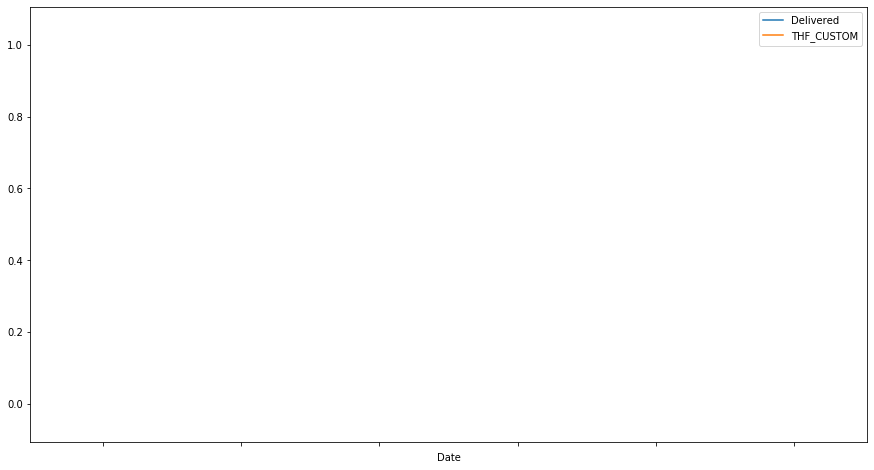

In [102]:
holdout = outcome[outcome['train/test/fc'] == 'holdout']
if not holdout.empty:
    holdout[['Date', 'Delivered', 'THF_CUSTOM']].groupby('Date', as_index=False).sum()[['Date', 'Delivered', 'THF_CUSTOM']].plot(figsize=[15,8], x='Date')
    print('Delivered', outcome[outcome['train/test/fc'] == 'holdout']['Delivered'].sum())

outcome[['Date', 'Delivered', 'THF_CUSTOM']].groupby('Date', as_index=False).sum()[['Date', 'Delivered', 'THF_CUSTOM']].plot(figsize=[15,8], x='Date')
print('THF_CUSTOM', outcome[outcome['train/test/fc'] == 'holdout']['THF_CUSTOM'].sum())

In [103]:
# holdout = extended_outcome[extended_outcome['train/test/fc'] == 'holdout']
# if not holdout.empty:
#     holdout[['Date', 'Delivered', 'THF_CUSTOM','thf_fbprophet_advanced_pp', 'thf_fbprophet_advanced', 'thf_xgb_tree_features_simple_pp']].groupby('Date', as_index=False).sum()[['Date', 'Delivered', 'THF_CUSTOM', 'thf_fbprophet_advanced_pp', 'thf_fbprophet_advanced', 'thf_xgb_tree_features_simple_pp']].plot(figsize=[15,8], x='Date')


In [104]:
# extended_outcome[['Date', 'Delivered', 'thf_fbprophet_advanced_pp', 'thf_fbprophet_advanced', 'thf_xgb_tree_features_simple_pp']].groupby('Date', as_index=False).sum()[['Date', 'Delivered', 'thf_fbprophet_advanced_pp', 'thf_fbprophet_advanced', 'thf_xgb_tree_features_simple_pp']].plot(figsize=[15,8], x='Date')


In [105]:
sales[sales.key.isin(outcome.key.unique())][['Date', 'Ship Discount on date']].plot(x='Date')

KeyError: "['Ship Discount on date'] not in index"

In [106]:
key = '5362 V087 021053 089026 089521'
if key in outcome.key.unique():
    outcome[outcome.key == '5362 V087 021053 089026 089521'][['Delivered', 'THF_CUSTOM']].plot()

In [107]:
key = '5362 V087 021053 089026 089521'
if key in sales.key.unique():
    sample = sales[sales.key == key][FEATURES_SIMPLE]
    sample.head()

In [108]:
key = '5362 V087 021053 089026 089521'
if key in sales.key.unique():
    sales[(sales.key == key) & (sales['Ship Discount on date'] >= 0)].groupby('DoW').agg({'Delivered':[sum, 'mean']})

In [109]:

if hold_out_dates:
    forecast_start_date =  min(hold_out_dates)
elif test_dates:
    forecast_start_date =  min(test_dates)
else:
    forecast_start_date = sales[sales['train/test/fc'] == 'train/test'].Date.max() + pd.Timedelta(1, unit='D')

print('forecast_start_date', forecast_start_date)

outcome['forecast_start_date'] = forecast_start_date


ValueError: The truth value of a DatetimeIndex is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [353]:
# raise
outcome_filename = r'..\{}\{}_outcome_{}.csv'.format('output_data', OUTPUT_PREFIX, OUTPUT_SUFFIX)
outcome.to_csv(outcome_filename, index=False)
print(outcome_filename)

extended_outcome.to_csv(r'..\{}\{}_extended_outcome_{}.csv'.format('output_data', OUTPUT_PREFIX, OUTPUT_SUFFIX), index=False)
best_models.to_csv(r'..\{}\{}_best_models_{}.csv'.format('output_data', OUTPUT_PREFIX, OUTPUT_SUFFIX), index=False)


..\output_data\trn_outcome_2020-03-02_v2_7_8_art_v5.csv


(<matplotlib.axes._subplots.AxesSubplot at 0x1fd01bb1a08>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1fd01c44a88>)

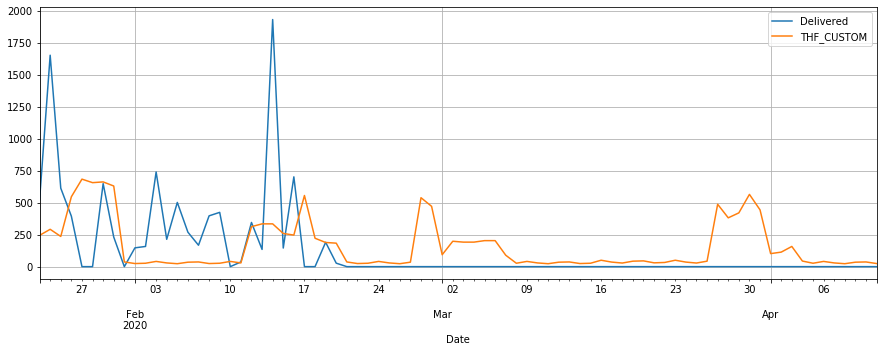

In [354]:
outcome[['Date', 'Delivered', 'THF_CUSTOM']].groupby('Date').sum().plot(grid=True), \
outcome[outcome['train/test/fc'] != 'train/test'][['Date', 'Delivered', 'THF_CUSTOM']].groupby('Date').sum().plot(grid=True)

In [355]:
for part in data['train/test/fc'].unique():
    print(f'last date in {part}: ', data[data['train/test/fc'] == part]['Date'].max())

last date in train/test:  2020-01-22 00:00:00
last date in holdout:  2020-02-18 00:00:00
last date in test:  2020-02-20 00:00:00
last date in fc:  2020-04-11 00:00:00


### FA report by weeks: Holdout

In [356]:
def split_by_weeks(dates): 
    week = list()
    for date in dates:
        week.append(date)
        week_day = pd.Timestamp(date).weekday_name
        
        if week_day == 'Sunday':            
            yield week
            week = list()

In [357]:
# mark custom weeks used for test: 
hold_out = outcome[outcome['train/test/fc'] == 'holdout']    
dates = sorted(hold_out['Date'].unique())

rolling_weeks = split_by_weeks(dates)

hold_out['hold_out_rweek_number'] = ''
for idx, rweek in enumerate(rolling_weeks):
    hold_out.loc[hold_out.Date.isin(rweek), ['hold_out_rweek_number']] = f'w{idx}'
    
    
gr_hold_out = hold_out[['key', 'Date', 'hold_out_rweek_number', 'Delivered', 'THF_CUSTOM']].groupby(['key', 'hold_out_rweek_number'], as_index=False)
report = gr_hold_out.agg({'Date': ['min', 'max'], 'Delivered': 'sum', 'THF_CUSTOM': 'sum'}, )
report.columns =  [' '.join(col).strip().replace(' ', '_') for col in report.columns.values]
report.rename(columns={'Delivered_sum': 'Delivered', 'THF_CUSTOM_sum': 'THF_CUSTOM'}, inplace=True)
report['AE'] = abs(report.Delivered - report.THF_CUSTOM)
report['FA'] = 1 - report.AE/report.Delivered
report['FA'] = report['FA'].apply(lambda x: 0 if x == -np.inf else x )

report['FA_gt_zero'] = report['FA'].clip(lower=0)

In [358]:
for rw in ['w1', 'w2', 'w3']:
    rw_report = report[report.hold_out_rweek_number == rw]
    error = rw_report.AE.sum()
    act = rw_report.Delivered.sum()
    fa = (1 - error/act)*100
    print(rw, round(fa, 2))
    
total_report = report[report.hold_out_rweek_number.isin(['w1', 'w2', 'w3'])]
total_error = total_report.AE.sum()
total_act = total_report.Delivered.sum()
total_fa = (1 - total_error/total_act)*100
print('total', round(total_fa, 2))

w1 -29.64
w2 7.93
w3 47.25
total 19.76


In [359]:
report['forecast_start_date'] = forecast_start_date
report_filename = r'..\{}\{}_report_{}.csv'.format('output_data', OUTPUT_PREFIX, OUTPUT_SUFFIX)
print(report_filename)
report.to_csv(report_filename, index=False)


..\output_data\trn_report_2020-03-02_v2_7_8_art_v5.csv


#### by Cats

In [360]:
report['Location'] = ''
report['Customer'] = ''
report['Product ID'] = '' 
report['nfa'] = '' 
report['rfa'] = ''

report[['Location', 'Customer', 'Product ID', 'nfa', 'rfa']] = report.key.str.split(expand=True)
for col in ['Location', 'Customer', 'nfa', 'rfa']:
    del report[col]
    
for cat in focus_categories:
    print(cat)
    focus_products = product_hier[product_hier['Category Description'] == cat]['Product ID'].unique()
    df_focus_products = pd.DataFrame(focus_products, columns=['Product ID'])
    df_focus_products['Product ID'] = df_focus_products['Product ID'].astype(str).str.zfill(6).values

    cat_report = df_focus_products.merge(report)

    for rw in ['w1', 'w2', 'w3']:
        rw_report = cat_report[cat_report.hold_out_rweek_number == rw]
        error = rw_report.AE.sum()
        act = rw_report.Delivered.sum()
        fa = (1 - error/act)*100
        print(rw, round(fa, 2))

    total_report = cat_report[cat_report.hold_out_rweek_number.isin(['w1', 'w2', 'w3'])]
    total_error = total_report.AE.sum()
    total_act = total_report.Delivered.sum()
    total_fa = (1 - total_error/total_act)*100
    print('total', round(total_fa, 2))
    

Густые йогурты
w1 nan
w2 nan
w3 nan
total nan
Творожные десерты
w1 -29.64
w2 7.93
w3 47.25
total 19.76
Питьевые йогурты
w1 nan
w2 nan
w3 nan
total nan
Функциональные напитки
w1 nan
w2 nan
w3 nan
total nan


### FA report by weeks: Test 

In [361]:
# mark custom weeks used for test: 
hold_out = outcome[outcome['train/test/fc'] == 'test']    
dates = sorted(hold_out['Date'].unique())
    
        
rolling_weeks = split_by_weeks(dates)

hold_out['hold_out_rweek_number'] = ''
for idx, rweek in enumerate(rolling_weeks):
    hold_out.loc[hold_out.Date.isin(rweek), ['hold_out_rweek_number']] = f'w{idx}'
    
    
gr_hold_out = hold_out[['key', 'Date', 'hold_out_rweek_number', 'Delivered', 'THF_CUSTOM']].groupby(['key', 'hold_out_rweek_number'], as_index=False)
report = gr_hold_out.agg({'Date': ['min', 'max'], 'Delivered': 'sum', 'THF_CUSTOM': 'sum'}, )
report.columns =  [' '.join(col).strip().replace(' ', '_') for col in report.columns.values]
report.rename(columns={'Delivered_sum': 'Delivered', 'THF_CUSTOM_sum': 'THF_CUSTOM'}, inplace=True)
report['AE'] = abs(report.Delivered - report.THF_CUSTOM)
report['FA'] = 1 - report.AE/report.Delivered
report['FA'] = report['FA'].apply(lambda x: 0 if x == -np.inf else x )

report['FA_gt_zero'] = report['FA'].clip(lower=0)

for rw in ['w0', 'w1', 'w2',]:
    rw_report = report[report.hold_out_rweek_number == rw]
    error = rw_report.AE.sum()
    act = rw_report.Delivered.sum()
    fa = (1 - error/act)*100
    print(rw, round(fa, 2))
    
total_report = report[report.hold_out_rweek_number.isin(['w1', 'w2', 'w3'])]
total_error = total_report.AE.sum()
total_act = total_report.Delivered.sum()
total_fa = (1 - total_error/total_act)*100
print('total', round(total_fa, 2))

w0 nan
w1 nan
w2 nan
total nan


In [362]:
# for rweek in report.hold_out_rweek_number.unique():
# _report = report[report.hold_out_rweek_number == 'w1'].FA_gt_zero.hist()
report[report.hold_out_rweek_number == 'w0'].FA_gt_zero.hist()

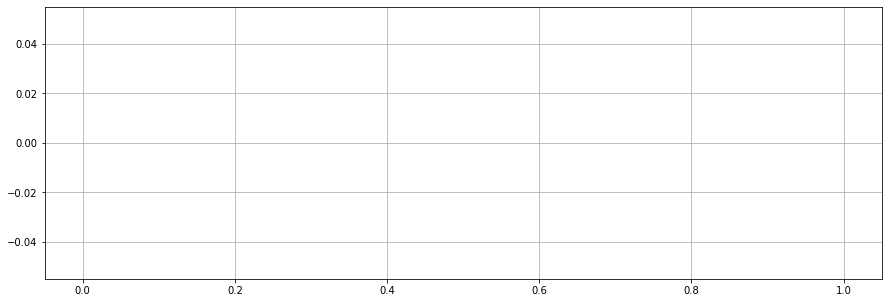

In [363]:
report[report.hold_out_rweek_number == 'w1'].FA_gt_zero.hist()

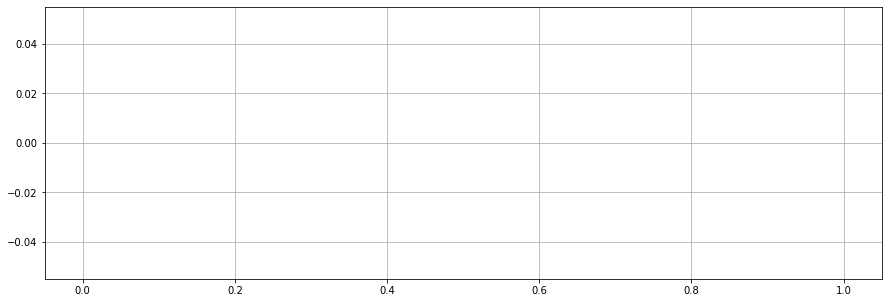

In [364]:
report[report.hold_out_rweek_number == 'w2'].FA_gt_zero.hist()

In [365]:
# mark custom weeks used for test: 
hold_out = extended_outcome[extended_outcome['train/test/fc'] == 'holdout']    
dates = sorted(hold_out['Date'].unique())
    
        
rolling_weeks = split_by_weeks(dates)

hold_out['hold_out_rweek_number'] = ''
for idx, rweek in enumerate(rolling_weeks):
    hold_out.loc[hold_out.Date.isin(rweek), ['hold_out_rweek_number']] = f'w{idx}'
    
for col in ['thf_fbprophet_advanced_pp', 'thf_fbprophet_advanced', 'thf_xgb_tree_features_simple_pp']:    
    print(col)
    
    gr_hold_out = hold_out[['key', 'Date', 'hold_out_rweek_number', 'Delivered', col]].groupby(['key', 'hold_out_rweek_number'], as_index=False)
    report = gr_hold_out.agg({'Date': ['min', 'max'], 'Delivered': 'sum', col: 'sum'}, )
    report.columns =  [' '.join(col).strip().replace(' ', '_') for col in report.columns.values]
    report.rename(columns={'Delivered_sum': 'Delivered', f'{col}_sum': col}, inplace=True)
    report['AE'] = abs(report.Delivered - report[col])
    report['FA'] = 1 - report.AE/report.Delivered
    report['FA'] = report['FA'].apply(lambda x: 0 if x == -np.inf else x )

    report['FA_gt_zero'] = report['FA'].clip(lower=0)

    for rw in ['w1', 'w2', 'w3',]:
        rw_report = report[report.hold_out_rweek_number == rw]
        error = rw_report.AE.sum()
        act = rw_report.Delivered.sum()
        fa = (1 - error/act)*100
        print(rw, round(fa, 2))
    
# total_report = report[report.hold_out_rweek_number.isin(['w1', 'w2', 'w3'])]
# total_error = total_report.AE.sum()
# total_act = total_report.Delivered.sum()
# total_fa = (1 - total_error/total_act)*100
# print('total', round(total_fa, 2))

thf_fbprophet_advanced_pp


KeyError: "['thf_fbprophet_advanced_pp'] not in index"

### check couple worst predicted keys

In [ ]:
mean_fa_report = report[report.hold_out_rweek_number.isin(['w1', 'w2', 'w3'])][['key', 'FA']].groupby('key').mean().sort_values('FA')
mean_fa_report

In [ ]:
sample = sales[sales.key == mean_fa_report.index[0] ]
train_x = sample[sample['train/test/fc'] == 'train/test'][FEATURES_SIMPLE]
train_y = sample[sample['train/test/fc'] == 'train/test']['Delivered']

m = XGB_PP()
m.fit(train_x, train_y)


In [ ]:
sample

In [ ]:
max_value = m.PP['Profile Promo'].max()
max_value_pp_day = m.PP[m.PP['Profile Promo'] == max_value]['number start ship discount'].values[0]

In [ ]:
sample = sample[FEATURES_SIMPLE + ['Delivered',]]

In [ ]:
sample['is_max_value_pp_day'] = np.where(sample['number start ship discount'] == max_value_pp_day, 1, 0)

In [ ]:
sample

In [ ]:


for key in mean_fa_report[mean_fa_report.FA < 0.0].index.unique():
    sample = outcome[outcome.key == key ][['Date','Delivered', 'THF_CUSTOM']]
    sample.plot(x='Date', title=key)

In [ ]:
sales[['Date', 'key']].groupby('key', as_index=False).count().hist()

In [ ]:
sales[['Date', 'key']].groupby('key', as_index=False).count().sort_values('Date')

In [ ]:
short_history_keys = ['5362 V087 100711 089027 089689', '5401 V087 100711 089017 089506']

In [ ]:
sales[sales.key.isin(short_history_keys)]['Delivered'].sum(), sales[~sales.key.isin(short_history_keys)]['Delivered'].sum() 

In [ ]:
for key in short_history_keys:
    sample = sales[sales.key == key][['Date', 'Delivered']]
    sample.plot(x='Date', figsize=(15, 5), grid=True)

In [ ]:
sales.columns